## EQUITIES FOR 2022 Q1-Q3

### Outline
1. Load and clean data
2. Filter for high novelty events (start with top 20% threshold)
3. Load and prep price data for one equity
4. Join news and price data
5. Define a simple trading rule (ex. short)
6. Evaluate performance
7. Create control group (mid or bottom 20% to compare to)
8. Re-run and evaluate with new threshold or differnet trading signal

### Imports

In [4]:
import pandas as pd
import os
import wrds
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from numpy import sqrt
import statsmodels.api as sm

### Data Imports

In [6]:
news = pd.read_csv("ravenpack_cleaned.csv")

C:\Users\mq45\AppData\Local\Temp\5\ipykernel_13904\3394891059.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  news = pd.read_csv("ravenpack_cleaned.csv")


### EDA With Original Data

In [8]:
# clean data initial EDA
news.info()
news.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6713104 entries, 0 to 6713103
Data columns (total 28 columns):
 #   Column                Dtype  
---  ------                -----  
 0   rp_entity_id          object 
 1   entity_type           object 
 2   entity_name           object 
 3   position_name         object 
 4   country_code          object 
 5   relevance             int64  
 6   topic                 object 
 7   group                 object 
 8   type                  object 
 9   sub_type              object 
 10  property              object 
 11  evaluation_method     object 
 12  maturity              float64
 13  category              object 
 14  ens                   float64
 15  ens_similarity_gap    float64
 16  ens_key               object 
 17  ens_elapsed           float64
 18  g_ens                 float64
 19  event_similarity_key  object 
 20  news_type             object 
 21  source                object 
 22  rp_story_event_index  int64  
 23  rp_stor

,relevance,maturity,ens,ens_similarity_gap,ens_elapsed,g_ens,rp_story_event_index,rp_story_event_count,rpna_time_utc
count,6.713104e+06,5.000000,6.713104e+06,6.713104e+06,6.713104e+06,6.713104e+06,6.713104e+06,6.713104e+06,6.713104e+06
mean,9.417881e+01,4.600000,4.869981e+01,2.428861e+01,1.386124e+07,4.435690e+01,1.244465e+00,3.449443e+00,4.889930e+04
std,2.078001e+01,0.894427,4.345619e+01,4.077424e+01,7.939487e+07,4.260980e+01,8.753277e-01,3.232027e+00,1.951374e+04
min,2.000000e+01,3.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.399993e-02
25%,1.000000e+02,5.000000,0.000000e+00,4.100000e-04,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.682177e+04
50%,1.000000e+02,5.000000,4.200000e+01,7.290000e-03,5.440505e+05,3.200000e+01,1.000000e+00,2.000000e+00,4.624536e+04
75%,1.000000e+02,5.000000,1.000000e+02,3.498758e+01,2.656650e+06,1.000000e+02,1.000000e+00,4.000000e+00,6.555750e+04
max,1.000000e+02,5.000000,1.000000e+02,1.000000e+02,4.320394e+09,1.000000e+02,2.100000e+01,2.030000e+02,8.639999e+04


<Axes: >

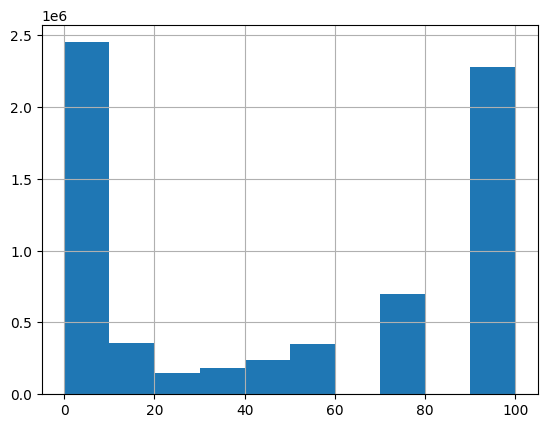

In [9]:
# histogram of ens (novelty) distribution
news["ens"].hist()

We see a lot (~2.5 million) data points with novelty scores near 0 and near 100. This means most articles are very relevant and new (high ENS) or very saturated and not new (low ENS). 

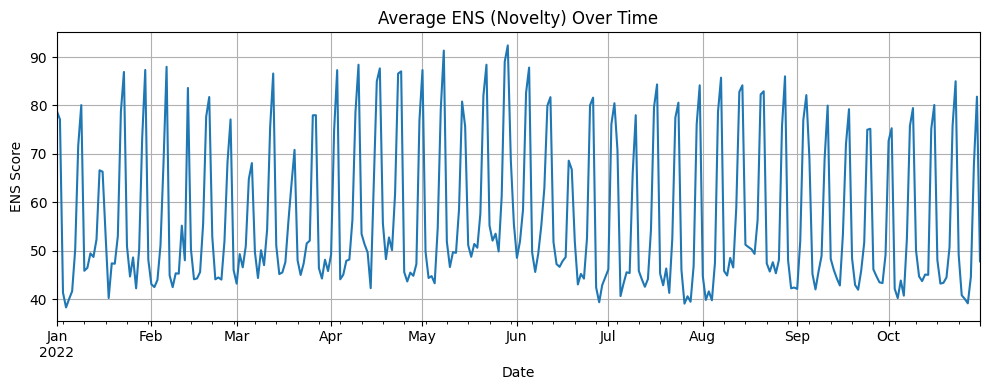

In [11]:
news["timestamp_utc"] = pd.to_datetime(news["timestamp_utc"])
news.set_index("timestamp_utc")["ens"].resample("D").mean().plot(figsize=(10,4))
plt.title("Average ENS (Novelty) Over Time")
plt.ylabel("ENS Score")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# top topics and entity types of news
print(news["topic"].value_counts().head(10))
print(news["entity_type"].value_counts())

topic
business    6541345
society      170337
economy        1198
politics        213
environm         11
Name: count, dtype: int64
entity_type
COMP    6713104
Name: count, dtype: int64


<Axes: xlabel='timestamp_utc'>

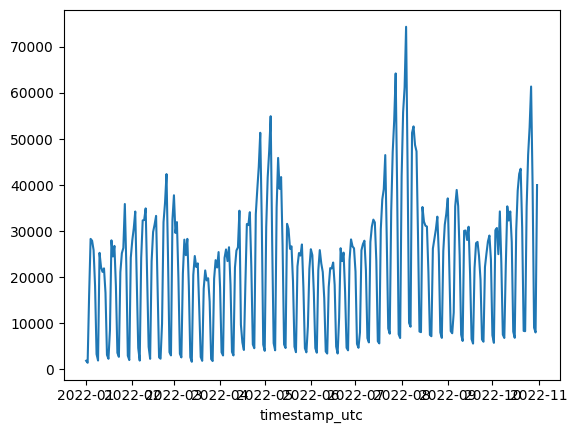

In [13]:
# plot of numbers of news articles by time
news["timestamp_utc"] = pd.to_datetime(news["timestamp_utc"])
news["timestamp_utc"].dt.date.value_counts().sort_index().plot()

### Novelty Score Filtering

In [15]:
# determine thresholds (0.8, 0.45-0.55, and 0.2)
high_novelty = news[news["ens"] >= news["ens"].quantile(0.8)]
mid_novelty = news[(news["ens"] >= news["ens"].quantile(0.45)) & (news["ens"] <= news["ens"].quantile(0.55))]
low_novelty = news[news["ens"] <= news["ens"].quantile(0.2)]

In [16]:
high_novelty = high_novelty.drop(columns=["g_ens","relevance","evaluation_method", "maturity","rp_entity_id", "position_name", "sub_type", "event_similarity_key", "source", "rp_story_event_index", "company"])
mid_novelty = mid_novelty.drop(columns=["g_ens","relevance","evaluation_method", "maturity","rp_entity_id", "position_name", "sub_type", "event_similarity_key", "source", "rp_story_event_index", "company"])
low_novelty = low_novelty.drop(columns=["g_ens","relevance","evaluation_method", "maturity","rp_entity_id", "position_name", "sub_type", "event_similarity_key", "source", "rp_story_event_index", "company"])

In [17]:
high_novelty.head()

,entity_type,entity_name,country_code,topic,group,type,property,category,ens,ens_similarity_gap,ens_key,ens_elapsed,news_type,rp_story_event_count,rpna_date_utc,rpna_time_utc,timestamp_utc
0,COMP,MusicMagpie PLC,GB,business,insider-trading,insider-buy,NaN,insider-buy,100.0,100.00000,7DE428C53B33EB02EE1DEAFF10C3EF5E,0.0,FULL-ARTICLE,3,2022-01-01,60258.729,2022-01-01 16:44:18.729
3,COMP,PriceSmart Inc.,US,business,acquisitions-mergers,stake,acquiree,stake-acquiree,100.0,13.33699,336C87EA6F00C45A0963F2A421146FB1,0.0,FULL-ARTICLE,3,2022-01-01,65008.919,2022-01-01 18:03:28.919
4,COMP,Park Aerospace Corp.,US,business,dividends,dividend,NaN,dividend,100.0,15.03097,83CD403C235C9D8BDB11103DCACBF6CA,0.0,NEWS-FLASH,1,2022-01-01,43968.826,2022-01-01 12:12:48.826
5,COMP,Wartsila Oyj,FI,business,analyst-ratings,analyst-ratings-change,NaN,analyst-ratings-change-negative,100.0,100.00000,D0046B62482DFD543EB35B7C3B17FCC0,0.0,FULL-ARTICLE,5,2022-01-01,24188.389,2022-01-01 06:43:08.389
7,COMP,Amazon.com Inc.,US,business,stock-prices,stock,NaN,stock-gain,100.0,1.06411,32D4B8BCD55C91C9EA006DDC3A45FE95,0.0,FULL-ARTICLE,8,2022-01-01,10329.558,2022-01-01 02:52:09.558


In [18]:
# change UTC to EST (AAPL recorded time) 
high_novelty["timestamp_utc"] = pd.to_datetime(high_novelty["timestamp_utc"])
high_novelty["timestamp_est"] = high_novelty["timestamp_utc"] - pd.Timedelta(hours=5)
high_novelty.drop(columns=["timestamp_utc", "rpna_time_utc", "rpna_date_utc", "ens_elapsed", "ens_key", "property"])

,entity_type,entity_name,country_code,topic,group,type,category,ens,ens_similarity_gap,news_type,rp_story_event_count,timestamp_est
0,COMP,MusicMagpie PLC,GB,business,insider-trading,insider-buy,insider-buy,100.0,100.00000,FULL-ARTICLE,3,2022-01-01 11:44:18.729
3,COMP,PriceSmart Inc.,US,business,acquisitions-mergers,stake,stake-acquiree,100.0,13.33699,FULL-ARTICLE,3,2022-01-01 13:03:28.919
4,COMP,Park Aerospace Corp.,US,business,dividends,dividend,dividend,100.0,15.03097,NEWS-FLASH,1,2022-01-01 07:12:48.826
5,COMP,Wartsila Oyj,FI,business,analyst-ratings,analyst-ratings-change,analyst-ratings-change-negative,100.0,100.00000,FULL-ARTICLE,5,2022-01-01 01:43:08.389
7,COMP,Amazon.com Inc.,US,business,stock-prices,stock,stock-gain,100.0,1.06411,FULL-ARTICLE,8,2021-12-31 21:52:09.558
...,...,...,...,...,...,...,...,...,...,...,...,...
6713099,COMP,FirstCash Holdings Inc.,US,business,insider-trading,insider-sell,insider-sell,100.0,100.00000,FULL-ARTICLE,1,2022-10-31 16:26:19.837
6713100,COMP,Argus Capital Corp.,US,business,acquisitions-mergers,stake,stake-acquiree,100.0,88.03056,FULL-ARTICLE,2,2022-10-31 06:18:41.509
6713101,COMP,Oxbridge Acquisition Corp.,KY,business,acquisitions-mergers,stake,stake-acquiree,100.0,86.95773,FULL-ARTICLE,3,2022-10-31 04:38:33.308
6713102,COMP,Davidson Kempner Capital Management LP,US,business,labor-issues,executive-resignation,executive-resignation,100.0,100.00000,FULL-ARTICLE,8,2022-10-31 10:53:31.178


In [19]:
# change for mid and low 
mid_novelty["timestamp_utc"] = pd.to_datetime(mid_novelty["timestamp_utc"])
mid_novelty["timestamp_est"] = mid_novelty["timestamp_utc"] - pd.Timedelta(hours=5)
low_novelty["timestamp_utc"] = pd.to_datetime(low_novelty["timestamp_utc"])
low_novelty["timestamp_est"] = low_novelty["timestamp_utc"] - pd.Timedelta(hours=5)
mid_novelty.drop(columns=["timestamp_utc", "rpna_time_utc", "rpna_date_utc", "ens_elapsed", "ens_key", "property"])
low_novelty.drop(columns=["timestamp_utc", "rpna_time_utc", "rpna_date_utc", "ens_elapsed", "ens_key", "property"])

,entity_type,entity_name,country_code,topic,group,type,category,ens,ens_similarity_gap,news_type,rp_story_event_count,timestamp_est
37,COMP,iTeos Therapeutics SA,BE,business,indexes,index-listing,index-listing,0.0,0.06839,FULL-ARTICLE,5,2021-12-31 19:51:18.109
38,COMP,iTeos Therapeutics SA,BE,business,indexes,index-listing,index-listing,0.0,0.01573,FULL-ARTICLE,5,2021-12-31 20:13:57.715
39,COMP,iTeos Therapeutics SA,BE,business,indexes,index-listing,index-listing,0.0,0.09522,NEWS-FLASH,3,2021-12-31 22:31:04.653
42,COMP,iTeos Therapeutics SA,BE,business,indexes,index-listing,index-listing,0.0,0.44793,FULL-ARTICLE,5,2022-01-01 09:16:05.858
49,COMP,Vail Resorts Inc.,US,business,acquisitions-mergers,acquisition,acquisition-completed-acquirer,0.0,0.03563,FULL-ARTICLE,1,2021-12-31 19:13:24.519
...,...,...,...,...,...,...,...,...,...,...,...,...
6712951,COMP,Landholdings Inc.,US,business,products-services,product-release,product-release,0.0,0.00005,NEWS-FLASH,1,2022-10-31 08:23:25.649
6712952,COMP,Landholdings Inc.,US,business,products-services,product-release,product-release,0.0,0.00066,FULL-ARTICLE,7,2022-10-31 08:24:22.809
6712953,COMP,Landholdings Inc.,US,business,products-services,product-release,product-release,0.0,0.00020,FULL-ARTICLE,5,2022-10-31 08:24:39.149
6712954,COMP,Landholdings Inc.,US,business,products-services,product-release,product-release,0.0,0.00036,FULL-ARTICLE,7,2022-10-31 08:25:10.078


### Equity Data and EDA

#### Equity Initial EDA

Below is where we change the import file (.csv) to the equity we want to test.

In [22]:
jbluq3 = pd.read_csv("jbluq3.csv", usecols=["DATE", "TIME_M", "PRICE"])
jbluq3.head()

,DATE,TIME_M,PRICE
0,2022-07-01,4:02:13.017594718,8.50
1,2022-07-01,4:26:28.481509268,8.47
2,2022-07-01,5:55:03.466890840,8.42
3,2022-07-01,7:00:00.025745969,8.41
4,2022-07-01,7:00:00.025755217,8.41


In [23]:
# equity load
jbluq3["timestamp"] = pd.to_datetime(jbluq3["DATE"] + " " + jbluq3["TIME_M"], errors="coerce")
jbluq3 = jbluq3.dropna(subset=["timestamp"]).sort_values("timestamp")

In [24]:
jbluq3

,DATE,TIME_M,PRICE,timestamp
0,2022-07-01,4:02:13.017594718,8.5000,2022-07-01 04:02:13.017594718
1,2022-07-01,4:26:28.481509268,8.4700,2022-07-01 04:26:28.481509268
2,2022-07-01,5:55:03.466890840,8.4200,2022-07-01 05:55:03.466890840
3,2022-07-01,7:00:00.025745969,8.4100,2022-07-01 07:00:00.025745969
4,2022-07-01,7:00:00.025755217,8.4100,2022-07-01 07:00:00.025755217
...,...,...,...,...
1500600,2022-08-30,10:47:18.687711376,7.9494,2022-08-30 10:47:18.687711376
1500601,2022-08-30,10:47:19.690615949,7.9500,2022-08-30 10:47:19.690615949
1500602,2022-08-30,10:47:19.690670505,7.9500,2022-08-30 10:47:19.690670505
1500603,2022-08-30,10:47:19.690831427,7.9500,2022-08-30 10:47:19.690831427


In [25]:
# add return column
jbluq3["future_price"] =jbluq3["PRICE"].shift(-1)  # start with 1 row ahead
jbluq3["return_1"] = (jbluq3["future_price"] - jbluq3["PRICE"]) / jbluq3["PRICE"]
jbluq3

,DATE,TIME_M,PRICE,timestamp,future_price,return_1
0,2022-07-01,4:02:13.017594718,8.5000,2022-07-01 04:02:13.017594718,8.4700,-0.003529
1,2022-07-01,4:26:28.481509268,8.4700,2022-07-01 04:26:28.481509268,8.4200,-0.005903
2,2022-07-01,5:55:03.466890840,8.4200,2022-07-01 05:55:03.466890840,8.4100,-0.001188
3,2022-07-01,7:00:00.025745969,8.4100,2022-07-01 07:00:00.025745969,8.4100,0.000000
4,2022-07-01,7:00:00.025755217,8.4100,2022-07-01 07:00:00.025755217,8.4100,0.000000
...,...,...,...,...,...,...
1500600,2022-08-30,10:47:18.687711376,7.9494,2022-08-30 10:47:18.687711376,7.9500,0.000075
1500601,2022-08-30,10:47:19.690615949,7.9500,2022-08-30 10:47:19.690615949,7.9500,0.000000
1500602,2022-08-30,10:47:19.690670505,7.9500,2022-08-30 10:47:19.690670505,7.9500,0.000000
1500603,2022-08-30,10:47:19.690831427,7.9500,2022-08-30 10:47:19.690831427,7.9499,-0.000013


##### 

#### floor to 60 mins

In [171]:
jbluq3["time_3min"] = jbluq3["timestamp"].dt.floor("3min")
jbluq3

,DATE,TIME_M,PRICE,timestamp,future_price,return_1,time_120min,price_lag,return_daily,time_60min,time_30min,time_10min,time_3min
0,2022-07-01,4:02:13.017594718,8.5000,2022-07-01 04:02:13.017594718,8.4700,-0.003529,2022-07-01 04:00:00,NaN,NaN,2022-07-01 04:00:00,2022-07-01 04:00:00,2022-07-01 04:00:00,2022-07-01 04:00:00
1,2022-07-01,4:26:28.481509268,8.4700,2022-07-01 04:26:28.481509268,8.4200,-0.005903,2022-07-01 04:00:00,8.5000,-0.003529,2022-07-01 04:00:00,2022-07-01 04:00:00,2022-07-01 04:20:00,2022-07-01 04:24:00
2,2022-07-01,5:55:03.466890840,8.4200,2022-07-01 05:55:03.466890840,8.4100,-0.001188,2022-07-01 04:00:00,8.4700,-0.005903,2022-07-01 05:00:00,2022-07-01 05:30:00,2022-07-01 05:50:00,2022-07-01 05:54:00
3,2022-07-01,7:00:00.025745969,8.4100,2022-07-01 07:00:00.025745969,8.4100,0.000000,2022-07-01 06:00:00,8.4200,-0.001188,2022-07-01 07:00:00,2022-07-01 07:00:00,2022-07-01 07:00:00,2022-07-01 07:00:00
4,2022-07-01,7:00:00.025755217,8.4100,2022-07-01 07:00:00.025755217,8.4100,0.000000,2022-07-01 06:00:00,8.4100,0.000000,2022-07-01 07:00:00,2022-07-01 07:00:00,2022-07-01 07:00:00,2022-07-01 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500600,2022-08-30,10:47:18.687711376,7.9494,2022-08-30 10:47:18.687711376,7.9500,0.000075,2022-08-30 10:00:00,7.9485,0.000113,2022-08-30 10:00:00,2022-08-30 10:30:00,2022-08-30 10:40:00,2022-08-30 10:45:00
1500601,2022-08-30,10:47:19.690615949,7.9500,2022-08-30 10:47:19.690615949,7.9500,0.000000,2022-08-30 10:00:00,7.9494,0.000075,2022-08-30 10:00:00,2022-08-30 10:30:00,2022-08-30 10:40:00,2022-08-30 10:45:00
1500602,2022-08-30,10:47:19.690670505,7.9500,2022-08-30 10:47:19.690670505,7.9500,0.000000,2022-08-30 10:00:00,7.9500,0.000000,2022-08-30 10:00:00,2022-08-30 10:30:00,2022-08-30 10:40:00,2022-08-30 10:45:00
1500603,2022-08-30,10:47:19.690831427,7.9500,2022-08-30 10:47:19.690831427,7.9499,-0.000013,2022-08-30 10:00:00,7.9500,0.000000,2022-08-30 10:00:00,2022-08-30 10:30:00,2022-08-30 10:40:00,2022-08-30 10:45:00


In [172]:
# group by mean 
jblu_3min = jbluq3.groupby("time_3min")["return_1"].mean().reset_index()
jblu_3min

,time_3min,return_1
0,2022-07-01 04:00:00,-0.003529
1,2022-07-01 04:24:00,-0.005903
2,2022-07-01 05:54:00,-0.001188
3,2022-07-01 07:00:00,-0.001189
4,2022-07-01 07:09:00,-0.000597
...,...,...
9815,2022-08-30 10:33:00,-0.000002
9816,2022-08-30 10:36:00,-0.000009
9817,2022-08-30 10:39:00,0.000007
9818,2022-08-30 10:42:00,-0.000004


##### Lag for testing impact after news (120 mins)

In [174]:
# lag for testing POST news
jblu_3min_lag = jblu_3min.copy()
jblu_3min_lag["time_3min"] = jblu_3min_lag["time_3min"] - pd.Timedelta(minutes=3)

### Equity EDA Merged with Novel
 When testing, we change the floor numbers and column values ("time_3min") to the timeframe we are testing, for example `time_60min" and dt.floor("60min"). 

In [176]:
# floor novelty dfs 
high_novelty["time_3min"] = high_novelty["timestamp_est"].dt.floor("3min")
high_novelty.sort_values("timestamp_est")
mid_novelty["time_3min"] = mid_novelty["timestamp_est"].dt.floor("3min")
mid_novelty.sort_values("timestamp_est")
low_novelty["time_3min"] = low_novelty["timestamp_est"].dt.floor("3min")
low_novelty.sort_values("timestamp_est")
high_novelty

,entity_type,entity_name,country_code,topic,group,type,property,category,ens,ens_similarity_gap,...,rp_story_event_count,rpna_date_utc,rpna_time_utc,timestamp_utc,timestamp_est,time_120min,time_60min,time_30min,time_10min,time_3min
0,COMP,MusicMagpie PLC,GB,business,insider-trading,insider-buy,NaN,insider-buy,100.0,100.00000,...,3,2022-01-01,60258.729,2022-01-01 16:44:18.729,2022-01-01 11:44:18.729,2022-01-01 10:00:00,2022-01-01 11:00:00,2022-01-01 11:30:00,2022-01-01 11:40:00,2022-01-01 11:42:00
3,COMP,PriceSmart Inc.,US,business,acquisitions-mergers,stake,acquiree,stake-acquiree,100.0,13.33699,...,3,2022-01-01,65008.919,2022-01-01 18:03:28.919,2022-01-01 13:03:28.919,2022-01-01 12:00:00,2022-01-01 13:00:00,2022-01-01 13:00:00,2022-01-01 13:00:00,2022-01-01 13:03:00
4,COMP,Park Aerospace Corp.,US,business,dividends,dividend,NaN,dividend,100.0,15.03097,...,1,2022-01-01,43968.826,2022-01-01 12:12:48.826,2022-01-01 07:12:48.826,2022-01-01 06:00:00,2022-01-01 07:00:00,2022-01-01 07:00:00,2022-01-01 07:10:00,2022-01-01 07:12:00
5,COMP,Wartsila Oyj,FI,business,analyst-ratings,analyst-ratings-change,NaN,analyst-ratings-change-negative,100.0,100.00000,...,5,2022-01-01,24188.389,2022-01-01 06:43:08.389,2022-01-01 01:43:08.389,2022-01-01 00:00:00,2022-01-01 01:00:00,2022-01-01 01:30:00,2022-01-01 01:40:00,2022-01-01 01:42:00
7,COMP,Amazon.com Inc.,US,business,stock-prices,stock,NaN,stock-gain,100.0,1.06411,...,8,2022-01-01,10329.558,2022-01-01 02:52:09.558,2021-12-31 21:52:09.558,2021-12-31 20:00:00,2021-12-31 21:00:00,2021-12-31 21:30:00,2021-12-31 21:50:00,2021-12-31 21:51:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6713099,COMP,FirstCash Holdings Inc.,US,business,insider-trading,insider-sell,NaN,insider-sell,100.0,100.00000,...,1,2022-10-31,77179.837,2022-10-31 21:26:19.837,2022-10-31 16:26:19.837,2022-10-31 16:00:00,2022-10-31 16:00:00,2022-10-31 16:00:00,2022-10-31 16:20:00,2022-10-31 16:24:00
6713100,COMP,Argus Capital Corp.,US,business,acquisitions-mergers,stake,acquiree,stake-acquiree,100.0,88.03056,...,2,2022-10-31,40721.510,2022-10-31 11:18:41.509,2022-10-31 06:18:41.509,2022-10-31 06:00:00,2022-10-31 06:00:00,2022-10-31 06:00:00,2022-10-31 06:10:00,2022-10-31 06:18:00
6713101,COMP,Oxbridge Acquisition Corp.,KY,business,acquisitions-mergers,stake,acquiree,stake-acquiree,100.0,86.95773,...,3,2022-10-31,34713.308,2022-10-31 09:38:33.308,2022-10-31 04:38:33.308,2022-10-31 04:00:00,2022-10-31 04:00:00,2022-10-31 04:30:00,2022-10-31 04:30:00,2022-10-31 04:36:00
6713102,COMP,Davidson Kempner Capital Management LP,US,business,labor-issues,executive-resignation,NaN,executive-resignation,100.0,100.00000,...,8,2022-10-31,57211.178,2022-10-31 15:53:31.178,2022-10-31 10:53:31.178,2022-10-31 10:00:00,2022-10-31 10:00:00,2022-10-31 10:30:00,2022-10-31 10:50:00,2022-10-31 10:51:00


In [177]:
# merge data
merged_high = pd.merge(high_novelty, jblu_3min, on="time_3min",how="inner")
merged_high = merged_high.drop(columns=["entity_type", "entity_name","property","ens_similarity_gap","ens_key","ens_elapsed","rpna_date_utc","rpna_time_utc","timestamp_utc","rpna_time_utc", "rpna_date_utc", "ens_elapsed", "ens_key", "property"])
merged_high

,country_code,topic,group,type,category,ens,news_type,rp_story_event_count,timestamp_est,time_120min,time_60min,time_30min,time_10min,time_3min,return_1
0,US,business,investor-relations,conference-call,conference-call,100.0,PRESS-RELEASE,1,2022-07-01 12:48:18.266,2022-07-01 12:00:00,2022-07-01 12:00:00,2022-07-01 12:30:00,2022-07-01 12:40:00,2022-07-01 12:48:00,0.000005
1,US,business,investor-relations,conference-call,conference-call,100.0,PRESS-RELEASE,1,2022-07-01 12:48:27.060,2022-07-01 12:00:00,2022-07-01 12:00:00,2022-07-01 12:30:00,2022-07-01 12:40:00,2022-07-01 12:48:00,0.000005
2,US,business,investor-relations,conference-call,conference-call,100.0,PRESS-RELEASE,1,2022-07-01 13:11:25.466,2022-07-01 12:00:00,2022-07-01 13:00:00,2022-07-01 13:00:00,2022-07-01 13:10:00,2022-07-01 13:09:00,0.000003
3,US,business,price-targets,price-target,price-target-set,100.0,FULL-ARTICLE,9,2022-07-01 05:54:28.994,2022-07-01 04:00:00,2022-07-01 05:00:00,2022-07-01 05:30:00,2022-07-01 05:50:00,2022-07-01 05:54:00,-0.001188
4,US,business,equity-actions,ownership,ownership-decrease-held,100.0,FULL-ARTICLE,8,2022-07-01 08:48:12.467,2022-07-01 08:00:00,2022-07-01 08:00:00,2022-07-01 08:30:00,2022-07-01 08:40:00,2022-07-01 08:48:00,0.000623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196331,US,business,partnerships,partnership,partnership,100.0,PRESS-RELEASE,1,2022-08-30 09:06:01.407,2022-08-30 08:00:00,2022-08-30 09:00:00,2022-08-30 09:00:00,2022-08-30 09:00:00,2022-08-30 09:06:00,-0.000083
196332,AU,business,analyst-ratings,analyst-ratings-set,analyst-ratings-set-positive,100.0,FULL-ARTICLE,2,2022-08-30 05:04:45.451,2022-08-30 04:00:00,2022-08-30 05:00:00,2022-08-30 05:00:00,2022-08-30 05:00:00,2022-08-30 05:03:00,0.006289
196333,AU,business,stock-prices,stock,stock-gain,100.0,NEWS-FLASH,2,2022-08-30 09:58:53.906,2022-08-30 08:00:00,2022-08-30 09:00:00,2022-08-30 09:30:00,2022-08-30 09:50:00,2022-08-30 09:57:00,-0.000020
196334,US,business,labor-issues,executive-appointment,executive-appointment,100.0,NEWS-FLASH,2,2022-08-29 19:03:22.850,2022-08-29 18:00:00,2022-08-29 19:00:00,2022-08-29 19:00:00,2022-08-29 19:00:00,2022-08-29 19:03:00,0.000000


Mean return after high novelty: -0.000017


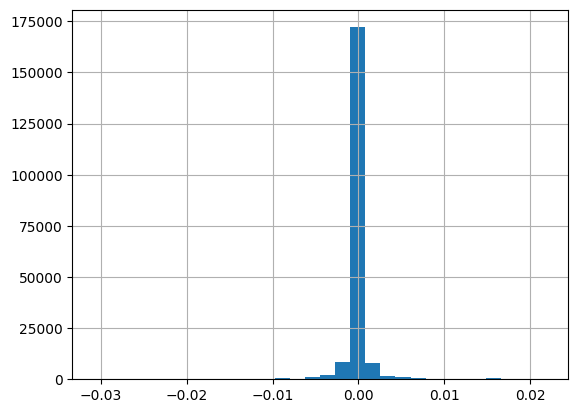

In [178]:
# eda
merged_high["return_1"].hist(bins=30)

merged_high["return_1"].describe()

mean_return = merged_high["return_1"].mean()
print(f"Mean return after high novelty: {mean_return:.6f}")

##### Test Data (mid and low novelty)

In [180]:
merged_mid = pd.merge(mid_novelty, jblu_3min, on="time_3min",how="inner")
merged_mid = merged_mid.drop(columns=["entity_type", "entity_name","property","ens_similarity_gap","ens_key","ens_elapsed","rpna_date_utc","rpna_time_utc","timestamp_utc","rpna_time_utc", "rpna_date_utc", "ens_elapsed", "ens_key", "property"])
merged_mid
merged_low = pd.merge(low_novelty, jblu_3min, on="time_3min",how="inner")
merged_low = merged_low.drop(columns=["entity_type", "entity_name","property","ens_similarity_gap","ens_key","ens_elapsed","rpna_date_utc","rpna_time_utc","timestamp_utc","rpna_time_utc", "rpna_date_utc", "ens_elapsed", "ens_key", "property"])
merged_low

,country_code,topic,group,type,category,ens,news_type,rp_story_event_count,timestamp_est,time_120min,time_60min,time_30min,time_10min,time_3min,return_1
0,US,business,investor-relations,conference-call,conference-call,0.0,FULL-ARTICLE,1,2022-07-01 13:27:28.859,2022-07-01 12:00:00,2022-07-01 13:00:00,2022-07-01 13:00:00,2022-07-01 13:20:00,2022-07-01 13:27:00,0.000008
1,US,business,investor-relations,conference-call,conference-call,0.0,FULL-ARTICLE,1,2022-07-01 13:27:59.474,2022-07-01 12:00:00,2022-07-01 13:00:00,2022-07-01 13:00:00,2022-07-01 13:20:00,2022-07-01 13:27:00,0.000008
2,US,business,investor-relations,conference-call,conference-call,0.0,FULL-ARTICLE,1,2022-07-01 13:28:40.385,2022-07-01 12:00:00,2022-07-01 13:00:00,2022-07-01 13:00:00,2022-07-01 13:20:00,2022-07-01 13:27:00,0.000008
3,US,business,investor-relations,conference-call,conference-call,0.0,FULL-ARTICLE,1,2022-07-01 13:29:05.869,2022-07-01 12:00:00,2022-07-01 13:00:00,2022-07-01 13:00:00,2022-07-01 13:20:00,2022-07-01 13:27:00,0.000008
4,US,business,investor-relations,conference-call,conference-call,0.0,FULL-ARTICLE,1,2022-07-01 13:29:21.043,2022-07-01 12:00:00,2022-07-01 13:00:00,2022-07-01 13:00:00,2022-07-01 13:20:00,2022-07-01 13:27:00,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294670,US,business,partnerships,partnership,partnership,0.0,FULL-ARTICLE,1,2022-08-30 09:53:58.889,2022-08-30 08:00:00,2022-08-30 09:00:00,2022-08-30 09:30:00,2022-08-30 09:50:00,2022-08-30 09:51:00,-0.000003
294671,US,business,partnerships,partnership,partnership,0.0,FULL-ARTICLE,1,2022-08-30 09:55:16.115,2022-08-30 08:00:00,2022-08-30 09:00:00,2022-08-30 09:30:00,2022-08-30 09:50:00,2022-08-30 09:54:00,0.000005
294672,US,business,partnerships,partnership,partnership,0.0,FULL-ARTICLE,1,2022-08-30 10:05:45.565,2022-08-30 10:00:00,2022-08-30 10:00:00,2022-08-30 10:00:00,2022-08-30 10:00:00,2022-08-30 10:03:00,-0.000017
294673,US,business,partnerships,partnership,partnership,0.0,FULL-ARTICLE,1,2022-08-30 10:15:08.677,2022-08-30 10:00:00,2022-08-30 10:00:00,2022-08-30 10:00:00,2022-08-30 10:10:00,2022-08-30 10:15:00,0.000004


##### Merge with lag data

In [182]:
merged_high_lag = pd.merge(high_novelty, jblu_3min_lag, on="time_3min", how="inner")
merged_mid_lag = pd.merge(mid_novelty, jblu_3min_lag, on="time_3min", how="inner")
merged_low_lag = pd.merge(low_novelty, jblu_3min_lag, on="time_3min", how="inner")
merged_high_lag = merged_high_lag.drop(columns=["entity_type", "entity_name","property","ens_similarity_gap","ens_key","ens_elapsed","rpna_date_utc","rpna_time_utc","timestamp_utc","rpna_time_utc", "rpna_date_utc", "ens_elapsed", "ens_key", "property"])
merged_mid_lag = merged_mid_lag.drop(columns=["entity_type", "entity_name","property","ens_similarity_gap","ens_key","ens_elapsed","rpna_date_utc","rpna_time_utc","timestamp_utc","rpna_time_utc", "rpna_date_utc", "ens_elapsed", "ens_key", "property"])
merged_low_lag = merged_low_lag.drop(columns=["entity_type", "entity_name","property","ens_similarity_gap","ens_key","ens_elapsed","rpna_date_utc","rpna_time_utc","timestamp_utc","rpna_time_utc", "rpna_date_utc", "ens_elapsed", "ens_key", "property"])

In [183]:
merged_high_lag

,country_code,topic,group,type,category,ens,news_type,rp_story_event_count,timestamp_est,time_120min,time_60min,time_30min,time_10min,time_3min,return_1
0,US,business,equity-actions,ownership,ownership-increase-held,100.0,FULL-ARTICLE,9,2022-07-01 08:39:17.736,2022-07-01 08:00:00,2022-07-01 08:00:00,2022-07-01 08:30:00,2022-07-01 08:30:00,2022-07-01 08:39:00,1.192605e-04
1,US,business,investor-relations,conference-call,conference-call,100.0,PRESS-RELEASE,1,2022-07-01 12:48:18.266,2022-07-01 12:00:00,2022-07-01 12:00:00,2022-07-01 12:30:00,2022-07-01 12:40:00,2022-07-01 12:48:00,1.300538e-05
2,US,business,investor-relations,conference-call,conference-call,100.0,PRESS-RELEASE,1,2022-07-01 12:48:27.060,2022-07-01 12:00:00,2022-07-01 12:00:00,2022-07-01 12:30:00,2022-07-01 12:40:00,2022-07-01 12:48:00,1.300538e-05
3,US,business,investor-relations,conference-call,conference-call,100.0,PRESS-RELEASE,1,2022-07-01 13:11:25.466,2022-07-01 12:00:00,2022-07-01 13:00:00,2022-07-01 13:00:00,2022-07-01 13:10:00,2022-07-01 13:09:00,1.476451e-05
4,US,business,equity-actions,ownership,ownership-decrease-held,100.0,FULL-ARTICLE,8,2022-07-01 08:48:12.467,2022-07-01 08:00:00,2022-07-01 08:00:00,2022-07-01 08:30:00,2022-07-01 08:40:00,2022-07-01 08:48:00,-4.733728e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195224,US,business,partnerships,partnership,partnership,100.0,PRESS-RELEASE,1,2022-08-30 09:06:00.585,2022-08-30 08:00:00,2022-08-30 09:00:00,2022-08-30 09:00:00,2022-08-30 09:00:00,2022-08-30 09:06:00,3.459239e-07
195225,US,business,partnerships,partnership,partnership,100.0,PRESS-RELEASE,1,2022-08-30 09:06:01.407,2022-08-30 08:00:00,2022-08-30 09:00:00,2022-08-30 09:00:00,2022-08-30 09:00:00,2022-08-30 09:06:00,3.459239e-07
195226,AU,business,stock-prices,stock,stock-gain,100.0,NEWS-FLASH,2,2022-08-30 09:58:53.906,2022-08-30 08:00:00,2022-08-30 09:00:00,2022-08-30 09:30:00,2022-08-30 09:50:00,2022-08-30 09:57:00,9.316835e-06
195227,US,business,labor-issues,executive-appointment,executive-appointment,100.0,NEWS-FLASH,2,2022-08-29 19:03:22.850,2022-08-29 18:00:00,2022-08-29 19:00:00,2022-08-29 19:00:00,2022-08-29 19:00:00,2022-08-29 19:03:00,-1.256281e-05


In [184]:
print("High:", merged_high_lag["return_1"].mean())
print("Mid:", merged_mid_lag["return_1"].mean())
print("Low:", merged_low_lag["return_1"].mean())

High: -4.402654017804473e-06
Mid: -5.38881184716623e-06
Low: -9.91437733825487e-07


Mean return after mid novelty: -0.000004


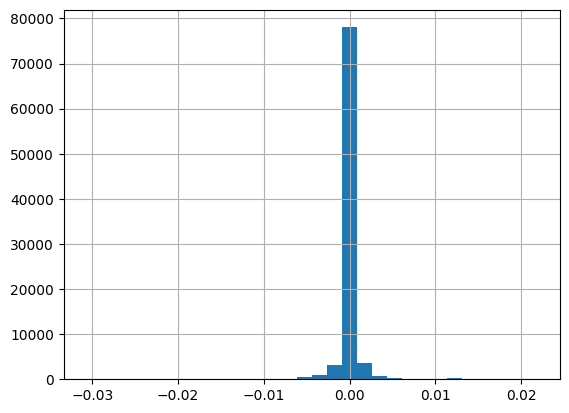

In [185]:
# eda mid test data
merged_mid["return_1"].hist(bins=30)

merged_mid["return_1"].describe()

mean_return_mid = merged_mid["return_1"].mean()
print(f"Mean return after mid novelty: {mean_return_mid:.6f}")

Mean return after low novelty: -0.000017


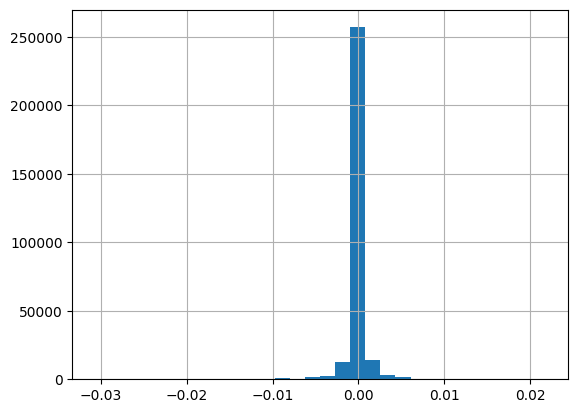

In [186]:
# eda low test data
merged_low["return_1"].hist(bins=30)

merged_low["return_1"].describe()

mean_return_low = merged_low["return_1"].mean()
print(f"Mean return after low novelty: {mean_return_low:.6f}")

##### High novelty merge with no lag

### TEST SIGNAL SUCCESS
#### Focusing on strategy -> need to test entry and exit times and give Sharpe / PnL

In [189]:
from scipy.stats import ttest_ind
# t-test

# High vs Mid
t1 = ttest_ind(merged_high_lag["return_1"], merged_mid_lag["return_1"])
print("High vs Mid:", t1)

# High vs Low
t2 = ttest_ind(merged_high_lag["return_1"], merged_low_lag["return_1"])
print("High vs Low:", t2)

# Mid vs Low
t3 = ttest_ind(merged_mid_lag["return_1"], merged_low_lag["return_1"])
print("Mid vs Low:", t3)

# high lag vs no lag
t4 = ttest_ind(merged_high_lag["return_1"], merged_high["return_1"])
print("High Lag vs High No Lag:", t4)

High vs Mid: TtestResult(statistic=0.15799410165598016, pvalue=0.8744615593411079, df=282804.0)
High vs Low: TtestResult(statistic=-0.8292538763352875, pvalue=0.40696116727579146, df=491254.0)
Mid vs Low: TtestResult(statistic=-0.8754162112931142, pvalue=0.38134803034372244, df=383602.0)
High Lag vs High No Lag: TtestResult(statistic=2.457469515274671, pvalue=0.01399239876872052, df=391563.0)


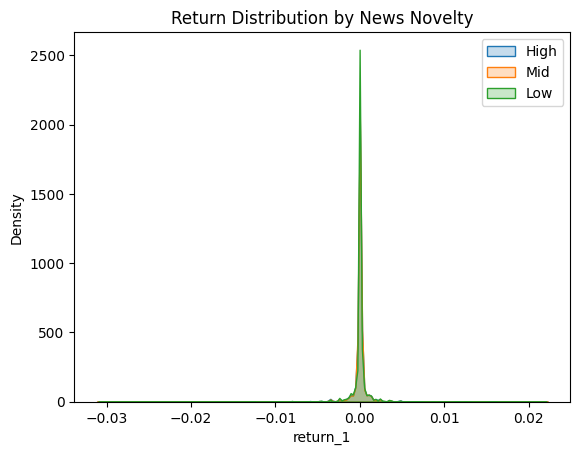

In [190]:
sns.kdeplot(merged_high_lag["return_1"], label="High", fill=True)
sns.kdeplot(merged_mid_lag["return_1"], label="Mid", fill=True)
sns.kdeplot(merged_low_lag["return_1"], label="Low", fill=True)
plt.title("Return Distribution by News Novelty")
plt.legend()
plt.show()

In [191]:
# PnL
capital = 100000

# Equal capital per trade (no reinvestment, no compounding)
capital_per_trade = capital / len(merged_high_lag)
merged_high_lag["pnl"] = merged_high_lag["return_1"] * capital_per_trade
merged_high_lag["cum_pnl"] = merged_high_lag["pnl"].cumsum()
final_pnl = merged_high_lag["cum_pnl"].iloc[-1]

print(f"Final High PnL: ${final_pnl:.2f}")

# Repeat for mid novelty
capital_per_trade = capital / len(merged_mid_lag)
merged_mid_lag["pnl"] = merged_mid_lag["return_1"] * capital_per_trade
merged_mid_lag["cum_pnl"] = merged_mid_lag["pnl"].cumsum()
final_pnl = merged_mid_lag["cum_pnl"].iloc[-1]

print(f"Final Mid PnL: ${final_pnl:.2f}")

# Repeat for low novelty
capital_per_trade = capital / len(merged_low_lag)
merged_low_lag["pnl"] = merged_low_lag["return_1"] * capital_per_trade
merged_low_lag["cum_pnl"] = merged_low_lag["pnl"].cumsum()
final_pnl = merged_low_lag["cum_pnl"].iloc[-1]

print(f"Final Low PnL: ${final_pnl:.2f}")

Final High PnL: $-0.44
Final Mid PnL: $-0.54
Final Low PnL: $-0.10


Text(0.5, 1.0, 'cumulative PnL from high novelty strat')

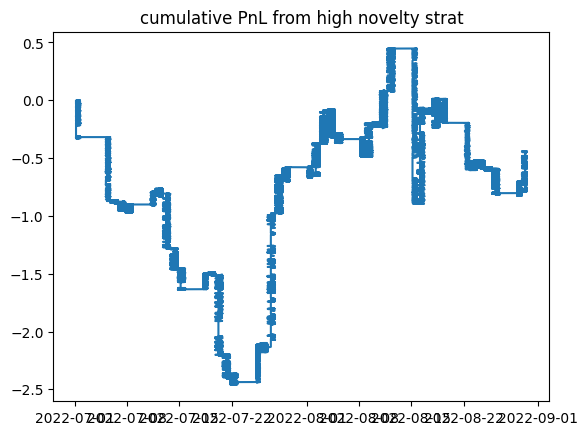

In [192]:
plt.plot(merged_high_lag["timestamp_est"], merged_high_lag["cum_pnl"])
plt.title("cumulative PnL from high novelty strat")

In [193]:
final_pnl = merged_high_lag["cum_pnl"].iloc[-1]
print("High novelty strategy final PnL: "+str(final_pnl))
final_pn2 = merged_mid_lag["cum_pnl"].iloc[-1]
print("Mid novelty strategy final PnL: "+str(final_pn2))
final_pn3 = merged_low_lag["cum_pnl"].iloc[-1]
print("Low novelty strategy final PnL: "+str(final_pn3))

High novelty strategy final PnL: -0.4402654017805173
Mid novelty strategy final PnL: -0.5388811847165906
Low novelty strategy final PnL: -0.09914377338264804


#### Other Success Metrics

# sharpe (annualized) 
#periods per year
# data is not only for trading hours 
trading_days = 252
trading_mins = 960
three_minval = trading_mins/3
ten_minval = trading_mins/10
thirty_minval = trading_mins/30
hour_val = trading_mins / 60
twohr_val = trading_mins / 120

r = merged_high_lag["return_1"].dropna()
sharpe_high = r.mean() / r.std() * sqrt(trading_days * thirty_minval)
print(f"Sharpe Ratio: {sharpe_high:.2f}")

r = merged_mid_lag["return_1"].dropna()
sharpe_mid = r.mean() / r.std() * sqrt(trading_days  * thirty_minval)
print(f"Sharpe Ratio: {sharpe_mid:.2f}")

r = merged_low_lag["return_1"].dropna()
sharpe_low = r.mean() / r.std() * sqrt(trading_days  * thirty_minval)
print(f"Sharpe Ratio: {sharpe_low:.2f}")

In [196]:
# sharpe non annualized
def compute_sharpe_scaled(df, label, holding_minutes, total_days=63):  # ~63 trading days in Q1
    r = df["return_1"].dropna()
    if r.std() == 0 or len(r) == 0:
        print(f"{label} Sharpe: N/A (zero std or no trades)")
        return None
    
    trading_minutes_per_day = 390  # 9:30am to 4pm
    total_periods = (total_days * trading_minutes_per_day) / holding_minutes
    
    sharpe = r.mean() / r.std() * sqrt(total_periods)
    print(f"{label} Sharpe (Q1, {holding_minutes}-min lag): {sharpe:.2f}")
    return sharpe

compute_sharpe_scaled(merged_high_lag, "High Novelty", holding_minutes=3)
compute_sharpe_scaled(merged_mid_lag, "Mid Novelty", holding_minutes=3)
compute_sharpe_scaled(merged_low_lag, "Low Novelty", holding_minutes=3)

High Novelty Sharpe (Q1, 3-min lag): -0.25
Mid Novelty Sharpe (Q1, 3-min lag): -0.35
Low Novelty Sharpe (Q1, 3-min lag): -0.07


-0.07024244381398469

In [197]:
# max drawdown
# high
cum_pnl_high = merged_high_lag["cum_pnl"]
roll_max_high = cum_pnl_high.cummax()
drawdown_high = cum_pnl_high - roll_max_high
max_drawdown_high = drawdown_high.min()
print(f"Max Drawdown High: {max_drawdown_high}")

max_drawdown_pct_high = (max_drawdown_high / capital) * 100
print(f"Max Drawdown High (%): {max_drawdown_pct_high}%")

# mid
cum_pnl_mid = merged_mid_lag["cum_pnl"]
roll_max_mid = cum_pnl_mid.cummax()
drawdown_mid = cum_pnl_mid - roll_max_mid
max_drawdown_mid = drawdown_mid.min()
print(f"Max Drawdown Mid: {max_drawdown_mid}")

max_drawdown_pct_mid = (max_drawdown_mid / capital) * 100
print(f"Max Drawdown Midi (%): {max_drawdown_pct_mid}%")

# low
cum_pnl_low = merged_low_lag["cum_pnl"]
roll_max_low = cum_pnl_low.cummax()
drawdown_low = cum_pnl_low - roll_max_low
max_drawdown_low = drawdown_low.min()
print(f"Max Drawdown Low: {max_drawdown_low}")

max_drawdown_pct_low = (max_drawdown_low / capital) * 100
print(f"Max Drawdown Low (%): {max_drawdown_pct_low}%")

Max Drawdown High: -2.4591465239719397
Max Drawdown High (%): -0.0024591465239719398%
Max Drawdown Mid: -1.9186687751885327
Max Drawdown Midi (%): -0.0019186687751885328%
Max Drawdown Low: -1.3189550825734326
Max Drawdown Low (%): -0.0013189550825734326%


In [198]:
# turnover 
# high
num_trades_high = len(merged_high_lag)
capital_per_trade_high = capital / num_trades_high
turnover_high = (num_trades_high * capital_per_trade_high) / capital
print(f"Turnover Rate High: {turnover_high}")

# mid
num_trades_mid = len(merged_mid_lag)
capital_per_trade_mid = capital / num_trades_mid
turnover_mid = (num_trades_mid * capital_per_trade_mid) / capital
print(f"Turnover Rate Mid: {turnover_mid}")

#low
num_trades_low = len(merged_low_lag)
capital_per_trade_low = capital / num_trades_low
turnover_low = (num_trades_low * capital_per_trade_low) / capital
print(f"Turnover Rate Low: {turnover_low}")

Turnover Rate High: 0.9999999999999999
Turnover Rate Mid: 1.0
Turnover Rate Low: 1.0


## For Small-Cap: Compare to buy&hold

In [200]:
start_price = jbluq3["PRICE"].iloc[0]
end_price = jbluq3["PRICE"].iloc[-2]

buy_hold_return = (end_price - start_price) / start_price
print(f"Buy-and-Hold Return for Q1: {buy_hold_return:.4%}")

Buy-and-Hold Return for Q1: -6.4706%


In [201]:
# pnl
capital = 100000
buy_hold_pnl = buy_hold_return * capital
print(f"Buy-and-Hold PnL for Q1: ${buy_hold_pnl:.2f}")

Buy-and-Hold PnL for Q1: $-6470.59


In [202]:
# sharpe
jbluq3['price_lag'] = jbluq3["PRICE"].shift(1)
jbluq3["return_daily"] = (jbluq3["PRICE"] - jbluq3["price_lag"]) / jbluq3["price_lag"]

daily_returns = jbluq3["return_daily"].dropna()

sharpe_bh = daily_returns.mean() / daily_returns.std() * np.sqrt(len(daily_returns))
print(f"Buy-and-Hold Sharpe (Q1): {sharpe_bh:.2f}")


Buy-and-Hold Sharpe (Q1): 0.29


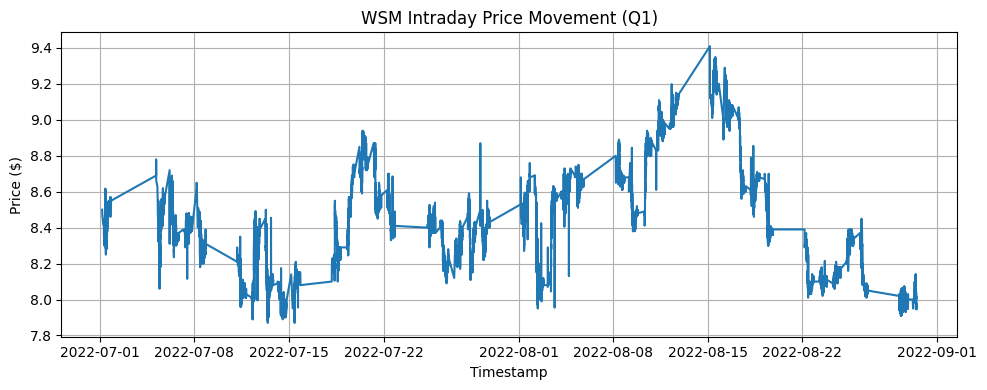

In [203]:
# price over time
plt.figure(figsize=(10, 4))
plt.plot(jbluq3["timestamp"], jbluq3["PRICE"])
plt.title("WSM Intraday Price Movement (Q1)")
plt.xlabel("Timestamp")
plt.ylabel("Price ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [204]:
jbluq1['return_daily'].hist(bins=50, edgecolor='black')
plt.title("Distribution of Intraday Returns (WSM, Q1)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'jbluq1' is not defined